# Задание 1 (5 балла)

Имплементируйте алгоритм Леска (описание есть в семинаре) и оцените качество его работы на датасете `data/corpus_wsd_50k.txt`

В качестве метрики близости вы должны попробовать два подхода:

1) Jaccard score на множествах слов (определений и контекста)
2) Cosine distance на эмбедингах sentence_transformers

В качестве метрики используйте accuracy (% правильных ответов). Предсказывайте только многозначные слова в датасете

Контекст вы можете определить самостоятельно (окно вокруг целевого слова или все предложение). Также можете поэкспериментировать с предобработкой для обоих методов.

In [ ]:
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sentence_transformers import SentenceTransformer

In [ ]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embed = model.encode

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
model.device

device(type='cuda', index=0)

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.corpus import wordnet as wn

In [ ]:
corpus = open('corpus_wsd_50k.txt').read().split('\n\n')

In [ ]:
from collections import defaultdict

In [ ]:
def get_word_info(instance, cosine=False):
  whole_context = []
  all_polysemy_words = defaultdict(dict)
  for num, line in enumerate(instance.split('\n')):
      sep_words = line.split()
      if len(sep_words) > 2:
          whole_context.append(sep_words[2])
      else:
          whole_context.append(sep_words[1])
          continue
      all_polysemy_words[sep_words[2]]['definition'] = sep_words[0]
      all_polysemy_words[sep_words[2]]['lemma'] = sep_words[1]
      all_polysemy_words[sep_words[2]]['word_pos'] = num
  for x in all_polysemy_words:
      all_polysemy_words[x]['context'] = whole_context
  return all_polysemy_words

In [ ]:
def jaccard_algorithm(definition, context):
    intersection = (set(definition.split()) & set(context.split()))
    union = (set(definition.split()) | set(context.split()))
    jaccard =  len(intersection) / len(union)
    return jaccard

In [ ]:
def cosine_distance(definition, context):
    return cosine_distances(definition.reshape(1, -1), context.reshape(1, -1))[0][0]

In [ ]:
import numpy as np

In [ ]:
# я знаю, что это не очень красиво так делать,
# но я объявлю словарь с эмбеддингами определений, потому что не получила их все изначально
# сильно переписывать функцию не хочется, а из словаря вытаскивать уже возможные посчитанный эмбеддинги побыстрее
emb_dict = {}

In [ ]:
def lesk_algorithm(word: str, instance: dict, metric: str, window: int=None):
    word_lemma_key = instance['definition']
    lemma = instance['lemma']
    word_definition = wn.lemma_from_key(word_lemma_key).synset().definition()
    word_pos = instance['word_pos']

    # определения всех значений слова
    all_definitions = [x.definition() for x in wn.synsets(lemma)]

    new_context = [x for x in instance['context']]
    new_context[word_pos] = '_'

    # выборк контекста
    if window is None:
        new_context = ' '.join(new_context)
    else:
        prev_cont = word_pos-window if window <= word_pos else 0
        ant_cont = word_pos+window if word_pos+window < len(new_context) else len(new_context)
        new_context = ' '.join(new_context[prev_cont:ant_cont])

    # выбор метрики
    answer = []
    match metric:
      case 'jaccard':
          jaccard_metric = [jaccard_algorithm(x, new_context)  for x in all_definitions]
          max_definition = np.argmax(jaccard_metric)
          if all_definitions[max_definition] == word_definition:
              return True
          else:
              return False
      case 'cos_dist':
          to_embed = [x for x in all_definitions if x not in emb_dict]

          for x, y in zip(embed(to_embed), to_embed):
              emb_dict[y] = x

          context_emb = embed(new_context)
          cosine_metric = [cosine_distance(emb_dict[x], context_emb)  for x in all_definitions]
          def_min_dist = np.argmin(cosine_metric)
          if all_definitions[def_min_dist] == word_definition:
              return True
          else:
              return False
      case _:
        return

In [ ]:
from tqdm import tqdm

In [ ]:
all_words = 0
correct_answers_default = 0
correct_answers_window_10 = 0
correct_answers_window_6 = 0
correct_answers_window_4 = 0
for line in tqdm(corpus):
    polysemy_words = get_word_info(line)
    for word in polysemy_words:
      all_words += 1
      correct_answers_default += 1 if lesk_algorithm(word, polysemy_words[word], 'jaccard') else 0
      correct_answers_window_10 += 1 if lesk_algorithm(word, polysemy_words[word], 'jaccard', window=10) else 0
      correct_answers_window_6 += 1 if lesk_algorithm(word, polysemy_words[word], 'jaccard', window=6) else 0
      correct_answers_window_4 += 1 if lesk_algorithm(word, polysemy_words[word], 'jaccard', window=4) else 0

100%|██████████| 49452/49452 [03:00<00:00, 274.19it/s] 


In [ ]:
print('Jaccard score')
print('-'*25)
print(f'Весь контекст: {(correct_answers_default / all_words):.2f}')
print(f'Контекст – 10 слов: {(correct_answers_window_10 / all_words):.2f}')
print(f'Контекст – 6 слов: {(correct_answers_window_6 / all_words):.2f}')
print(f'Контекст – 4 слова {(correct_answers_window_4 / all_words):.2f}')

Jaccard score
-------------------------
Весь контекст: 0.30
Контекст – 10 слов: 0.31
Контекст – 6 слов: 0.32
Контекст – 4 слова 0.34


In [ ]:
def get_word_info_emb(instance, cosine=False):
  whole_context = []
  all_polysemy_words = defaultdict(dict)
  for num, line in enumerate(instance.split('\n')):
      sep_words = line.split()
      if len(sep_words) > 2:
          whole_context.append(sep_words[2])
      else:
          whole_context.append(sep_words[1])
          continue
      all_polysemy_words[sep_words[2]]['definition'] = sep_words[0]
      all_polysemy_words[sep_words[2]]['lemma'] = sep_words[1]
      all_polysemy_words[sep_words[2]]['word_pos'] = num
  for x in all_polysemy_words:
      all_polysemy_words[x]['context'] = whole_context
  return all_polysemy_words

In [ ]:
all_words = 0
cosine_correct_answers_window_4 = 0
for line in tqdm(corpus):
    polysemy_words = get_word_info(line)
    for word in polysemy_words:
      all_words += 1
      cosine_correct_answers_window_4 += 1 if lesk_algorithm(word, polysemy_words[word], 'cos_dist', window=4) else 0

100%|██████████| 49452/49452 [1:09:50<00:00, 11.80it/s]


In [ ]:
print('Cosine distance (minimal) | Cosine similarity | With SentenceEmbs')
print('-'*50)
print(f'Контекст – 4 слова {(cosine_correct_answers_window_4 / all_words):.2f}')

Cosine distance (minimal) | Cosine similarity | With SentenceEmbs
--------------------------------------------------
Контекст – 4 слова 0.35


# Задание 2 (5 балла)
Попробуйте разные алгоритмы кластеризации на датасете - `https://github.com/nlpub/russe-wsi-kit/blob/initial/data/main/wiki-wiki/train.csv`

Используйте код из семинара как основу. Используйте ARI как метрику качества.

Попробуйте все 4 алгоритма кластеризации, про которые говорилось на семинаре. Для каждого из алгоритмов попробуйте настраивать гиперпараметры (посмотрите их в документации). Прогоните как минимум 5 экспериментов (не обязательно успешных) с разными параметрами на каждый алгоритме кластеризации и оцените: качество кластеризации, скорость работы, интуитивность параметров.

Помимо этого также выберите 1 дополнительный алгоритм кластеризации отсюда - https://scikit-learn.org/stable/modules/clustering.html , опишите своими словами принцип его работы  и проделайте аналогичные эксперименты.

In [154]:
!wget https://raw.githubusercontent.com/nlpub/russe-wsi-kit/initial/data/main/wiki-wiki/train.csv

--2025-10-04 14:01:23--  https://raw.githubusercontent.com/nlpub/russe-wsi-kit/initial/data/main/wiki-wiki/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 365614 (357K) [text/plain]
Saving to: ‘train.csv.1’

train.csv.1         100%[===================>] 357.04K  --.-KB/s    in 0.005s  

2025-10-04 14:01:23 (70.2 MB/s) - ‘train.csv.1’ saved [365614/365614]



In [155]:
import pandas as pd

In [156]:
df = pd.read_csv('train.csv', sep='\t')

In [157]:
df.head()

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,1,замок,1,NaN,"0-5, 339-344",замок владимира мономаха в любече . многочисле...
1,2,замок,1,NaN,"11-16, 17-22, 188-193","шильонский замок замок шильйон ( ) , известный..."
2,3,замок,1,NaN,299-304,проведения архитектурно - археологических рабо...
3,4,замок,1,NaN,111-116,"топи с . , л . белокуров легенда о завещании м..."
4,5,замок,1,NaN,"134-139, 262-267",великий князь литовский гедимин после успешной...


In [158]:
grouped_df = df.groupby('word')[['word', 'context', 'gold_sense_id']]

In [159]:
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation
import numpy as np
from sklearn.metrics import adjusted_rand_score

In [160]:
grouped_df.head()

,word,context,gold_sense_id
0,замок,замок владимира мономаха в любече . многочисле...,1
1,замок,"шильонский замок замок шильйон ( ) , известный...",1
2,замок,проведения архитектурно - археологических рабо...,1
3,замок,"топи с . , л . белокуров легенда о завещании м...",1
4,замок,великий князь литовский гедимин после успешной...,1
138,лук,"они были основными слушателями баллад , а криз...",1
139,лук,якутский лук якутский лук принадлежит к северн...,1
140,лук,"из всех трех типов луков — классики , олимпика...",1
141,лук,английский длинный лук английский длинный лук ...,1
142,лук,металлических утяжелителей дуг . составной лук...,1


In [161]:
len(grouped_df.get_group('замок')['context'].values)

138

In [182]:
def get_metric(df, algo, word, **kwargs):
    parameters = kwargs
    texts = df.get_group(word)['context'].values
    X = np.zeros((len(texts), 768))

    batches = []
    batch_size = 16
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        batches.append(batch)
    processed = 0
    for batch in batches:
        for i, vector in enumerate(embed(batch)):
            i += processed
            X[i] = vector
        processed += len(batch)

    match algo:
      case 'DBSCAN':
        if not 'min_samples' in parameters:
            parameters['min_samples'] = 1
        if not 'eps' in parameters:
            parameters['eps'] = 0.1

        cluster = DBSCAN(**parameters)
      case 'AffProp':
        cluster = AffinityPropagation(**parameters)
      case 'AggClust':
          if 'distance_threshold' in parameters:
              parameters['n_clusters'] = None
          cluster = AgglomerativeClustering(**parameters)
      case 'Kmeans':
          if 'n_clusters' not in parameters:
              parameters['n_clusters'] = 3
          cluster = KMeans(**parameters)
      case 'SpectClust':
          if 'n_clusters' not in parameters:
              parameters['n_clusters'] = 3
          cluster = SpectralClustering(**parameters)

    cluster.fit(X)
    labels = np.array(cluster.labels_)+1

    return adjusted_rand_score(df.get_group(word)['gold_sense_id'], labels)


## DBSCAN

In [188]:
import time

In [191]:
start_time_1 = time.time()
ARI_default = [get_metric(grouped_df, 'DBSCAN', key) for key, _ in grouped_df]
end_time_1 = time.time()
start_time_2 = time.time()
ARI_cosine = [get_metric(grouped_df, 'DBSCAN', key, metric='cosine') for key, _ in grouped_df]
end_time_2 = time.time()

In [193]:
print(f'Стандартный DBSCAN: {np.mean(ARI_default):.5f}\nВремя: {end_time_1-start_time_1}')
print('\n')
print(f'DBSCAN metric=cosine: {np.mean(ARI_default):.5f}\nВремя: {end_time_2-start_time_2}')

Стандартный DBSCAN: 0.00105
Время: 11.02499008178711


DBSCAN metric=cosine: 0.00105
Время: 11.237125396728516


In [194]:
start_time_1 = time.time()
ARI_cosine_brute_eps = [get_metric(grouped_df, 'DBSCAN', key, eps=0.2, metric='cosine', algorithm='brute') for key, _ in grouped_df]
end_time_1 = time.time()

start_time_2 = time.time()
ARI_cosine_brute_eps_samples = [get_metric(grouped_df, 'DBSCAN', key, eps=0.2, min_samples=3, metric='cosine', algorithm='brute') for key, _ in grouped_df]
end_time_2 = time.time()

In [196]:
print(f'DBSCAN metric=cosine, algorithm=brute, eps=0.2: {np.mean(ARI_cosine_brute_eps):.5f}\nВремя: {end_time_1-start_time_1}')
print('\n')
print(f'DBSCAN metric=cosine, algorithm=brute, eps=0.2, samples=3: {np.mean(ARI_cosine_brute_eps_samples):.5f}\nВремя: {end_time_2-start_time_2}')

DBSCAN metric=cosine, algorithm=brute, eps=0.2: 0.07489
Время: 10.913528442382812


DBSCAN metric=cosine, algorithm=brute, eps=0.2, samples=3: 0.07306
Время: 11.150765419006348


In [197]:
start_time_1 = time.time()
ARI_cosine_brute_eps_samples_5 = [get_metric(grouped_df, 'DBSCAN', key, eps=0.2, min_samples=5, metric='cosine', algorithm='brute') for key, _ in grouped_df]
end_time_1 = time.time()

In [198]:
print(f'DBSCAN metric=cosine, algorithm=brute, eps=0.2, samples=5: {np.mean(ARI_cosine_brute_eps_samples_5):.5f}\nВремя: {end_time_1-start_time_1}')

DBSCAN metric=cosine, algorithm=brute, eps=0.2, samples=5: 0.08064
Время: 10.976757287979126


**Лучшая метрика** -- *0.08064*


---


```
metric=cosine, algorithm=brute, eps=0.2, samples=5
```

Среднее время: 10-11 секунд



## AffinityPropagation

In [199]:
start_time_1 = time.time()
ARI_default = [get_metric(grouped_df, 'AffProp', key, random_state=25) for key, _ in grouped_df]
end_time_1 = time.time()

start_time_2 = time.time()
ARI_damping = [get_metric(grouped_df, 'AffProp', key, damping=0.7, random_state=25) for key, _ in grouped_df]
end_time_2 = time.time()

start_time_3 = time.time()
ARI_damping_less = [get_metric(grouped_df, 'AffProp', key, damping=0.6, random_state=25) for key, _ in grouped_df]
end_time_3 = time.time()

In [200]:
print(f'Стандартный AffProp: {np.mean(ARI_default):.5f}\nВремя: {end_time_1-start_time_1}')
print('\n')
print(f'AffProp damping=0.7: {np.mean(ARI_damping):.5f}\nВремя: {end_time_2-start_time_2}')
print('\n')
print(f'AffProp damping=0.6: {np.mean(ARI_damping_less):.5f}\nВремя: {end_time_3-start_time_3}')

Стандартный AffProp: 0.04274
Время: 11.10112738609314


AffProp damping=0.7: 0.04155
Время: 11.455334901809692


AffProp damping=0.6: 0.04274
Время: 12.016026735305786


In [ ]:
start_time_1 = time.time()
ARI_damping_coverg = [get_metric(grouped_df, 'AffProp', key, damping=0.6, random_state=25, convergence_iter=30) for key, _ in grouped_df]
end_time_1 = time.time()

start_time_2 = time.time()
ARI_damping_iters = [get_metric(grouped_df, 'AffProp', key, damping=0.6, random_state=25) for key, _ in grouped_df]
end_time_2 = time.time()

In [201]:
print(f'AffProp damping=0.6, convergence_iter=30: {np.mean(ARI_damping_coverg):.5f}\nВремя: {end_time_1-start_time_1}')
print('\n')
print(f'AffProp damping=0.6, max_iter=300: {np.mean(ARI_damping_iters):.5f}\nВремя: {end_time_2-start_time_2}')

AffProp damping=0.6, convergence_iter=30: 0.04274
Время: 11.10112738609314


AffProp damping=0.6, max_iter=300: 0.04274
Время: 11.455334901809692


**Лучшая метрика** -- 0.04274 (стандартный AffProp)


---

среднее время -- 11-12 секунд

## Agglomerative clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [202]:
start_time_1 = time.time()
ARI_threshold = [get_metric(grouped_df, 'AggClust', key, distance_threshold=0.8) for key, _ in grouped_df]
end_time_1 = time.time()

start_time_2 = time.time()
ARI_clusters = [get_metric(grouped_df, 'AggClust', key, n_clusters=5) for key, _ in grouped_df]
end_time_2 = time.time()

start_time_3 = time.time()
ARI_cosine = [get_metric(grouped_df, 'AggClust', key, distance_threshold=0.8, metric='cosine', linkage='average') for key, _ in grouped_df]
end_time_3 = time.time()

In [203]:
print(f'Стандартный (threshold=0.8) AggClust: {np.mean(ARI_threshold):.5f}\nВремя: {end_time_1-start_time_1}')
print('\n')
print(f'AggClust n_clusters=5: {np.mean(ARI_clusters):.5f}\nВремя: {end_time_2-start_time_2}')
print('\n')
print(f'AggClust (threshold=0.8) metric=cosine, linkage=average: {np.mean(ARI_cosine):.5f}\nВремя: {end_time_3-start_time_3}')

Стандартный (threshold=0.8) AggClust: 0.03763
Время: 10.727065801620483


AggClust n_clusters=5: 0.03379
Время: 11.362627744674683


AggClust (threshold=0.8) metric=cosine, linkage=average: 0.00000
Время: 11.603286027908325


In [204]:
start_time_1 = time.time()
ARI_cosine_average = [get_metric(grouped_df, 'AggClust', key, distance_threshold=0.2, metric='cosine', linkage='average') for key, _ in grouped_df]
end_time_1 = time.time()

In [205]:
print(f'AggClust (threshold=0.2) metric=cosine, linkage=average: {np.mean(ARI_cosine_average):.5f}\nВремя: {end_time_1-start_time_1}')

AggClust (threshold=0.2) metric=cosine, linkage=average: 0.11555
Время: 11.034559488296509


In [206]:
start_time_1 = time.time()
ARI_cosine_average_2 = [get_metric(grouped_df, 'AggClust', key, distance_threshold=0.1, metric='cosine', linkage='average') for key, _ in grouped_df]
end_time_1 = time.time()

In [207]:
print(f'AggClust (threshold=0.1) metric=cosine, linkage=average: {np.mean(ARI_cosine_average_2):.5f}\nВремя: {end_time_1-start_time_1}')

AggClust (threshold=0.1) metric=cosine, linkage=average: 0.01794
Время: 11.859452962875366


In [208]:
start_time_1 = time.time()
ARI_cosine_single = [get_metric(grouped_df, 'AggClust', key, distance_threshold=0.2, metric='cosine', linkage='complete') for key, _ in grouped_df]
end_time_1 = time.time()

In [209]:
print(f'AggClust (threshold=0.2) metric=cosine, linkage=average: {np.mean(ARI_cosine_single):.5f}\nВремя: {end_time_1-start_time_1}')

AggClust (threshold=0.2) metric=cosine, linkage=average: 0.03909
Время: 11.447248935699463


In [210]:
start_time_1 = time.time()
ARI_cosine_average_3 = [get_metric(grouped_df, 'AggClust', key, distance_threshold=0.3, metric='cosine', linkage='average') for key, _ in grouped_df]
end_time_1 = time.time()

In [211]:
print(f'AggClust (threshold=0.3) metric=cosine, linkage=average: {np.mean(ARI_cosine_average_3):.5f}\nВремя: {end_time_1-start_time_1}')

AggClust (threshold=0.3) metric=cosine, linkage=average: 0.05477
Время: 11.232676982879639


Лучшая метрика -- **0.11555**


---


`AggClust (threshold=0.2) metric=cosine, linkage=average`

Среднее время: 11-12 секунд

## Kmeans

In [219]:
start_time_1 = time.time()
ARI_3_clusters = [get_metric(grouped_df, 'Kmeans', key, random_state=25) for key, _ in grouped_df]
end_time_1 = time.time()

start_time_2 = time.time()
ARI_2_clusters = [get_metric(grouped_df, 'Kmeans', key, n_clusters=2, random_state=25) for key, _ in grouped_df]
end_time_2 = time.time()

start_time_3 = time.time()
ARI_5_clusters = [get_metric(grouped_df, 'Kmeans', key, n_clusters=5, random_state=25) for key, _ in grouped_df]
end_time_3 = time.time()

In [220]:
print(f'Стандартный (n_clusters=3) Kmeans: {np.mean(ARI_3_clusters):.5f}\nВремя: {end_time_1-start_time_1}')
print('\n')
print(f'Kmeans n_clusters=2: {np.mean(ARI_2_clusters):.5f}\nВремя: {end_time_2-start_time_2}')
print('\n')
print(f'Kmeans n_clusters=5: {np.mean(ARI_5_clusters):.5f}\nВремя: {end_time_3-start_time_3}')

Стандартный (n_clusters=3) Kmeans: 0.05379
Время: 11.557048320770264


Kmeans n_clusters=2: 0.02282
Время: 12.537479639053345


Kmeans n_clusters=5: 0.03148
Время: 12.506959676742554


In [221]:
start_time_1 = time.time()
ARI_15_init = [get_metric(grouped_df, 'Kmeans', key, n_init=15, random_state=25) for key, _ in grouped_df]
end_time_1 = time.time()

start_time_2 = time.time()
ARI_20_init_5_clusters = [get_metric(grouped_df, 'Kmeans', key, n_init=20, n_clusters=5, random_state=25) for key, _ in grouped_df]
end_time_2 = time.time()

In [222]:
print(f'Стандартный (n_clusters=3) Kmeans + 15 попыток с разными центрами: {np.mean(ARI_15_init):.5f}\nВремя: {end_time_1-start_time_1}')
print('\n')
print(f'Kmeans n_clusters=5 + 20 попыток с разными центрами: {np.mean(ARI_20_init_5_clusters):.5f}\nВремя: {end_time_2-start_time_2}')

Стандартный (n_clusters=3) Kmeans + 15 попыток с разными центрами: 0.05656
Время: 13.3409104347229


Kmeans n_clusters=5 + 20 попыток с разными центрами: 0.07562
Время: 12.694476842880249


Лучшая метрика -- **0.07562**


---


`Kmeans n_clusters=5 + 20 попыток с разными центрами`

Среднее время: 12-13 секунд

## SpectralClustering

In [163]:
from sklearn.cluster import SpectralClustering

In [223]:
start_time_1 = time.time()
ARI_3_clusters = [get_metric(grouped_df, 'SpectClust', key, random_state=25) for key, _ in grouped_df]
end_time_1 = time.time()

start_time_2 = time.time()
ARI_5_clusters = [get_metric(grouped_df, 'SpectClust', key, n_clusters=5, random_state=25) for key, _ in grouped_df]
end_time_2 = time.time()

start_time_3 = time.time()
ARI_5_clusters_nn = [get_metric(grouped_df, 'SpectClust', key, n_clusters=5, affinity='nearest_neighbors', random_state=25) for key, _ in grouped_df]
end_time_3 = time.time()

In [224]:
print(f'Стандартный (n_clusters=3) SpectralClustering: {np.mean(ARI_3_clusters):.5f}\nВремя: {end_time_1-start_time_1}')
print('\n')
print(f'SpectralClustering (n_clusters=5): {np.mean(ARI_5_clusters):.5f}\nВремя: {end_time_2-start_time_2}')
print('\n')
print(f'SpectralClustering (n_clusters=5) affinity=nearest_neighbors: {np.mean(ARI_5_clusters_nn):.5f}\nВремя: {end_time_3-start_time_3}')

Стандартный (n_clusters=3) SpectralClustering: 0.05770
Время: 11.898951053619385


SpectralClustering (n_clusters=5): 0.06619
Время: 12.190648555755615


SpectralClustering (n_clusters=5) affinity=nearest_neighbors: 0.05635
Время: 12.325382471084595


In [225]:
start_time_1 = time.time()
ARI_5_clusters_nn_15 = [get_metric(grouped_df, 'SpectClust', key, n_clusters=5, affinity='nearest_neighbors', n_neighbors=15, random_state=25) for key, _ in grouped_df]
end_time_1 = time.time()


start_time_2 = time.time()
ARI_3_clusters_nn_10 = [get_metric(grouped_df, 'SpectClust', key, n_clusters=3, affinity='nearest_neighbors', n_neighbors=10, random_state=25) for key, _ in grouped_df]
end_time_2 = time.time()

In [226]:
print(f'SpectralClustering (n_clusters=5) affinity=nearest_neighbors n_neighbors=15: {np.mean(ARI_5_clusters_nn_15):.5f}\nВремя: {end_time_1-start_time_1}')
print('\n')
print(f'SpectralClustering (n_clusters=3) affinity=nearest_neighbors n_neighbors=8: {np.mean(ARI_3_clusters_nn_10):.5f}\nВремя: {end_time_2-start_time_2}')

SpectralClustering (n_clusters=5) affinity=nearest_neighbors n_neighbors=15: 0.05449
Время: 11.604997873306274


SpectralClustering (n_clusters=3) affinity=nearest_neighbors n_neighbors=8: 0.08330
Время: 11.706103801727295


Лучшая метрика -- **0.08330**



---


`SpectralClustering (n_clusters=3) affinity=nearest_neighbors n_neighbors=8`

Среднее время: 11-12 секунд

Spectral clustering работает через граф: мы смотрим на точки данных не как на координаты в пространстве, а как на вершины графа, соединённые рёбрами по мере их похожести. Получается, что кластеры — это группы точек, внутри которых связи плотнее, чем между разными группами. Чтобы это увидеть, берут матрицу лапласиана графа и находят её собственные векторы, которые показывают, где естественные разрывы в данных.

Дальше точки проецируются в новое пространство этих векторов, где границы между кластерами становятся более явными для разделения. На этом шаге применим обычный алгоритм типа KMeans, чтобы чётко выделить группы.


Подход особенно хорошо работает там, где кластеры имеют сложную форму чем шарики, как предполагает KMeans.

По сути, спектральная кластеризация улавливыет глобальную структуру данных за счёт анализа связей между объектами, а не только их геометрического положения.

Я не уверена, что она здесь реально подходит, но она меня заинтересовала, потому что не отталкивается как будто от идеальной формы в пространстве. Плюс картинка интересная

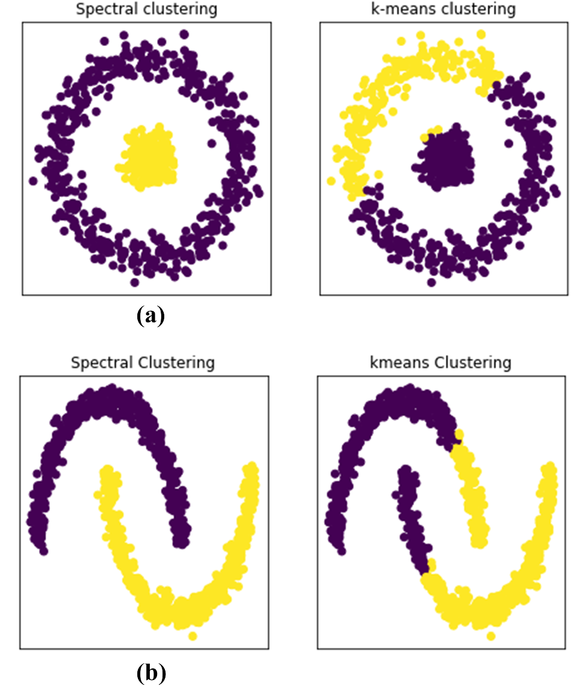

## Выводы

В итоге по времени все алгоритмы работали примерно одинаково, лучше всего сработалв агломеративная кластеризация.

Некоторые методы кластеризации как будто очень плохо подходят, потому что нужно подбирать все-таки количество кластеров, а подглядывать в gold-разметку – не очень правильно